# 3章 組み合わせのあるテスト：要素に分解して考える

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 61 seconds.


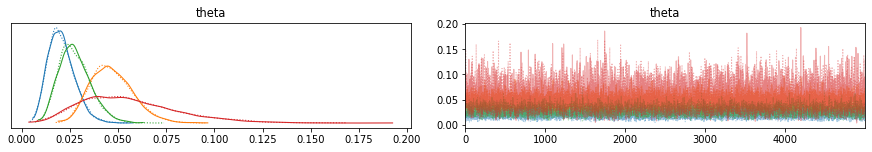

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz

# クリック率θのサンプルの軌跡
n = [434, 382, 394, 88]
clicks = [8, 17, 10, 4]
with pm.Model() as model:
    theta = pm.Uniform('theta', lower=0, upper=1, shape=len(n))
    obs = pm.Binomial('obs', p=theta, n=n, observed=clicks)
    trace = pm.sample(5000, chains=2)
    arviz.plot_trace(trace, compact=True)

           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_mean  \
theta[0]  0.021  0.007     0.009      0.034        0.0      0.0   12646.0   
theta[1]  0.047  0.011     0.027      0.068        0.0      0.0   14034.0   
theta[2]  0.028  0.008     0.013      0.044        0.0      0.0   11527.0   
theta[3]  0.056  0.025     0.013      0.105        0.0      0.0   13196.0   

           ess_sd  ess_bulk  ess_tail  r_hat  
theta[0]  11663.0   12394.0    7020.0    1.0  
theta[1]  13237.0   13788.0    8131.0    1.0  
theta[2]  10696.0   11501.0    7321.0    1.0  
theta[3]  11235.0   12963.0    6758.0    1.0  
0.9821
0.9415


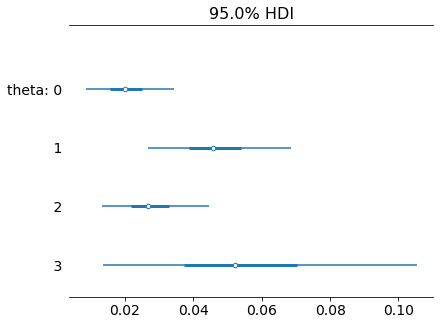

In [3]:
with model:
    # 確率変数θの要約統計量
    print(arviz.summary(trace, hdi_prob=0.95))

    # 確率変数θの事後分布の95%HDIの比較
    arviz.plot_forest(trace, combined=True, hdi_prob=0.95)

    # A案とB案のクリック率の差が正となる割合
    print((trace['theta'][:, 1] - trace['theta'][:, 0] > 0).mean())

    # A案とD案のクリック率の差が正となる割合
    print((trace['theta'][:, 3] - trace['theta'][:, 0] > 0).mean())

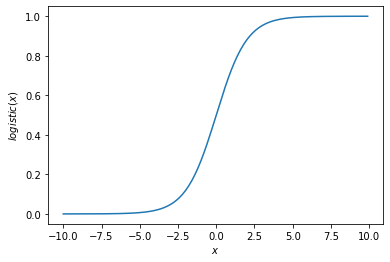

In [4]:
# ロジスティックス関数（シグモイド関数）
xs = np.arange(-10, 10, 0.1)
plt.plot(xs, 1 / (1 + np.exp(-xs)))
plt.xlabel(r'$x$')
plt.ylabel(r'$logistic(x)$')
plt.show()

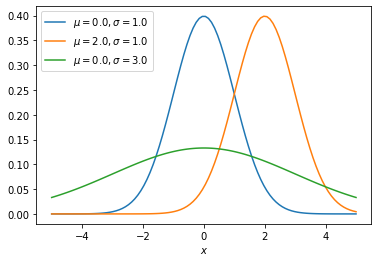

In [5]:
from scipy import stats

# さまざまな正規分布の例
x = np.linspace(-5, 5, 100)
params = [(0, 1), (2, 1), (0, 3)]
for mu, sigma in params:
    plt.plot(x, stats.norm.pdf(x, mu, sigma), label=r'$\mu=%.1f, \sigma=%.1f$' % (mu, sigma))

plt.legend()
plt.xlabel(r'$x$')
plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 97 seconds.


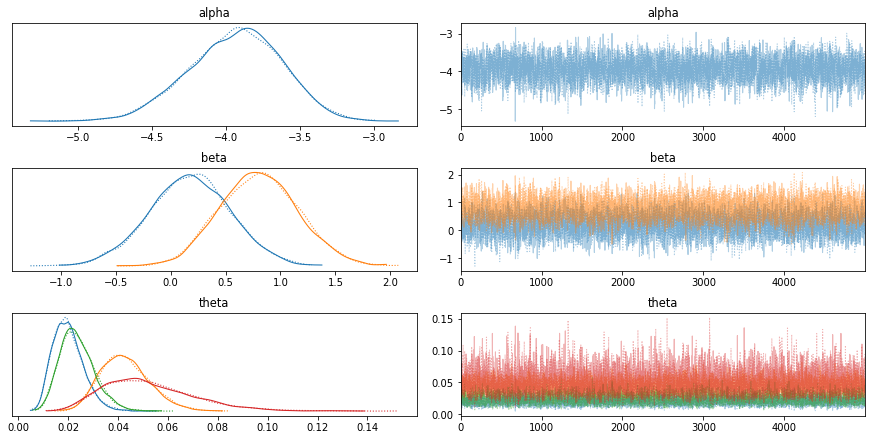

In [6]:
# 書き直した統計モデル
img = [0, 0, 1, 1]
btn = [0, 1, 0, 1]

with pm.Model() as model_comb:
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10, shape=2)
    comb = alpha + beta[0] * img + beta[1] * btn
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-comb)))
    obs = pm.Binomial('obs', p=theta, n=n, observed=clicks)
    trace_comb = pm.sample(5000, chains=2)
    # 得られたサンプルの軌跡を可視化
    arviz.plot_trace(trace_comb)

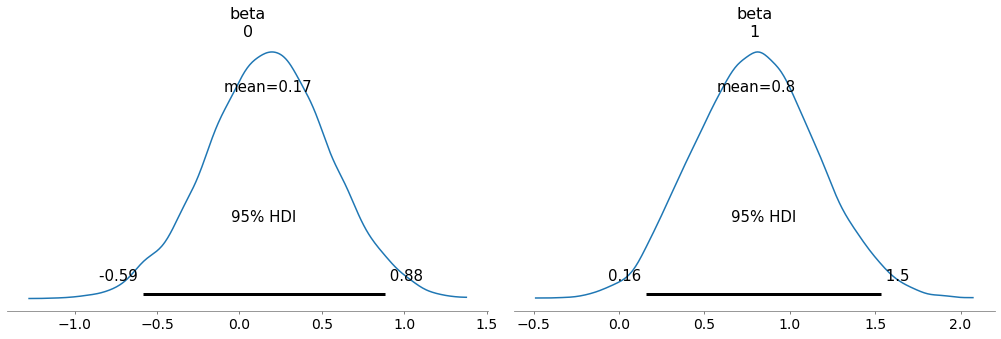

In [7]:
# βの事後分布の可視化
with model_comb:
    arviz.plot_posterior(trace_comb, var_names=['beta'], hdi_prob=0.95)

In [8]:
# ボタンの文言を変えることはクリック率に正の効果をもたらす
print((trace_comb['beta'][:, 1] > 0).mean())

0.99


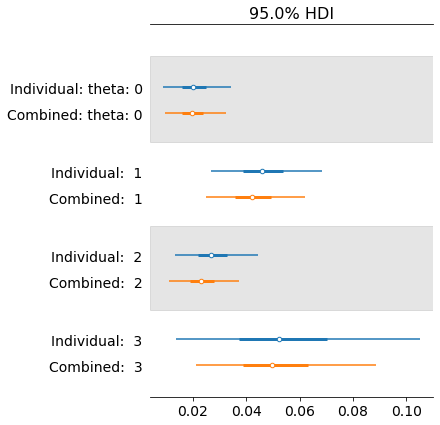

In [9]:
# クリック率θがデザイン案ごとに独立したモデル（Individual）と、施策効果によって接続されたモデル（Combined）それぞれについて得られた事後分布の95% HDIの比較
with pm.Model():
    arviz.plot_forest([trace, trace_comb], var_names=['theta'], hdi_prob=0.95, combined=True, model_names=['Individual', 'Combined'])

In [10]:
# A案とB案のクリック率の差が正となる割合
print((trace_comb['theta'][:, 1] - trace_comb['theta'][:, 0] > 0).mean())

# A案とD案のクリック率の差が正となる割合
print((trace_comb['theta'][:, 3] - trace_comb['theta'][:, 0] > 0).mean())

0.99
0.9517


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 99 seconds.


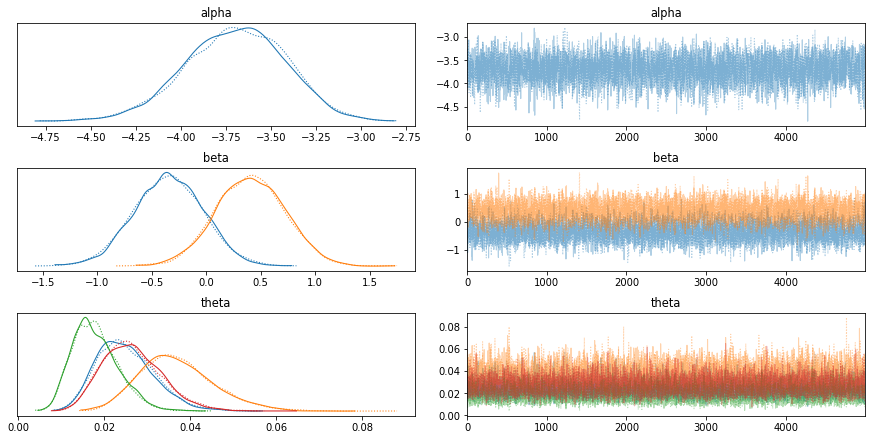

In [11]:
# 完成したレポートに、同じ統計モデルをあてはめたときのサンプルの軌跡
n = [434, 382, 394, 412]
clicks = [8, 17, 10, 8]
img = [0, 0, 1, 1]
btn = [0, 1, 0, 1]

with pm.Model() as model_comb2:
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10, shape=2)
    comb = alpha + beta[0] * img + beta[1] * btn
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-comb)))
    obs = pm.Binomial('obs', p=theta, n=n, observed=clicks)
    trace_comb2 = pm.sample(5000, chains=2)
    arviz.plot_trace(trace_comb2)

In [12]:
# 新しいデータにおいて”ボタンの文言を変えることはクリック率に正の効果をもたらす”は認められない
print((trace_comb2['beta'][:, 1] > 0).mean())

0.9017


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [gamma, beta, alpha]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 224 seconds.
The number of effective samples is smaller than 25% for some parameters.


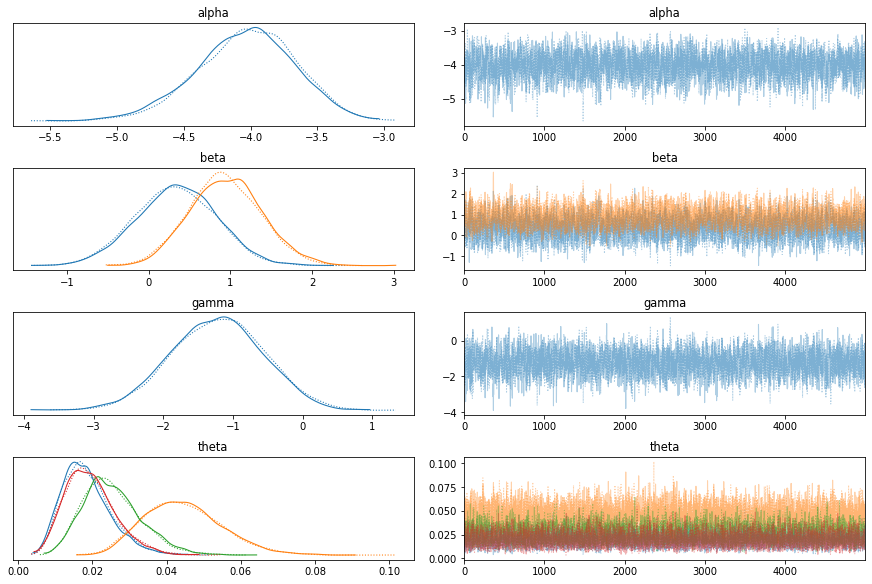

In [13]:
# 交互作用項を追加した統計モデルから得られたサンプルの軌跡
with pm.Model() as model_int:
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10, shape=2)
    gamma = pm.Normal('gamma', mu=0, sigma=10)
    comb = alpha + beta[0] * img + beta[1] * btn + gamma * img * btn
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-comb)))
    obs = pm.Binomial('obs', p=theta, n=n, observed=clicks)
    trace_int = pm.sample(5000, chains=2)
    arviz.plot_trace(trace_int)

In [14]:
# 確率変数γが負の値をとる確率
print((trace_int['gamma'] < 0).mean())

# ”ヒーロー画像を変えることはクリック率に正の効果をもたらす”は認められない
print((trace_int['beta'][:, 0] > 0).mean())
# ”ボタンの文言を変えることはクリック率に正の効果をもたらす”は認められる
print((trace_int['beta'][:, 1] > 0).mean())

0.9698
0.7529
0.9877


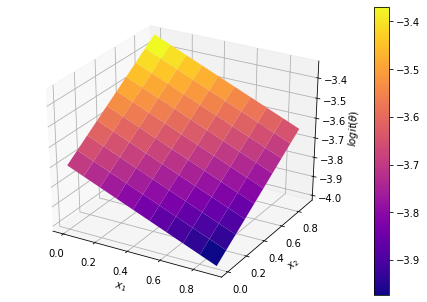

In [20]:
from mpl_toolkits.mplot3d import Axes3D

x1 = np.arange(0, 1, 0.1)
x2 = np.arange(0, 1, 0.1)
X1, X2 = np.meshgrid(x1, x2)

fig = plt.figure()
ax = Axes3D(fig)
logit_theta = (trace_comb2['alpha'].mean() + trace_comb2['beta'][:, 0].mean() * X1 + trace_comb2['beta'][:, 1].mean() * X2)
surf = ax.plot_surface(X1, X2, logit_theta, cmap='plasma')
fig.colorbar(surf)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_zlabel(r'$logit(\theta)$')
plt.show()

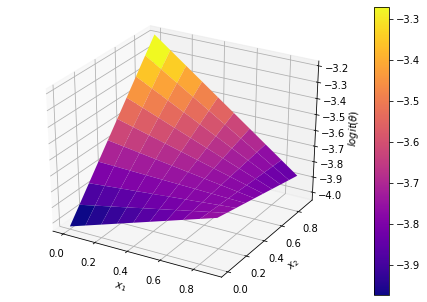

In [21]:
fig = plt.figure()
ax = Axes3D(fig)
Y = (trace_int['alpha'].mean() + trace_int['beta'][:, 0].mean() * X1 +
      trace_int['beta'][:, 1].mean() * X2 + trace_int['gamma'].mean() * X1 * X2)
surf = ax.plot_surface(X1, X2, Y, cmap='plasma')
fig.colorbar(surf)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_zlabel(r'$logit(\theta)$')
plt.show()

In [23]:
# モデル選択のための代表的な指標のひとつWAIC（値が小さいものほど良いモデル）
# https://docs.pymc.io/api/stats.html
waic_comb2 = arviz.waic(trace_comb2, model_comb2)
waic_int = arviz.waic(trace_int, model_int)
print(waic_comb2.p_waic)
print(waic_int.p_waic)

3.695170710535595
1.9672851545889762
